# 2. Разведочный анализ данных (EDA)

## 🚀 Цели этапа
1. Анализ распределения целевой переменной
2. Исследование категориальных признаков
3. Анализ числовых признаков  
4. Поиск корреляций и взаимосвязей
5. Формулировка выводов и гипотез

In [81]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../data/Churn_Modelling.csv')

df.info()

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
categorical_features = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
target = 'Exited'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


## 2.1 🎯Анализ целевой переменной

Анализируем дисбаланс классов - это критично для выбора метрик и стратегии борьбы с дисбалансом.

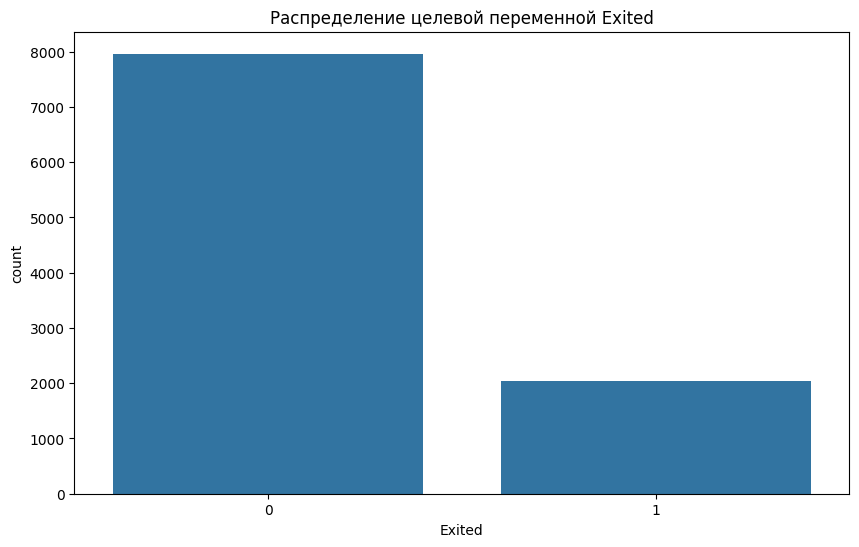

In [82]:
plt.figure(figsize=(10,6))
sb.countplot(data=df, x=target)
plt.title('Распределение целевой переменной Exited')
plt.show()

In [83]:
churn_count = df['Exited'].value_counts().min()
remaining_customers = df['Exited'].value_counts().max()
print(f"Сколько человек попали под отток: {churn_count}")
print(f"Сколько человек остались пользоваться услугами банака: {remaining_customers}")

Сколько человек попали под отток: 2038
Сколько человек остались пользоваться услугами банака: 7964


In [84]:
churn_rate = df['Exited'].value_counts(normalize=True) * 100
print(f"Процент оттока: {churn_rate[1]:.1f}%")

Процент оттока: 20.4%


Можем заметить, что у нас присутствует дисбаланс классов: из 10002 клиентов 2038 человек перестали пользоваться услугами банка, а 7964 остались преданны банку и продолжают пользоваться его услугами. Следовательно в дальнейшем этапе "Подготовка данных к обучению" мы будем использовать метода балансировки классов, чтобы наша модель давала более точные результаты

## 🔠 2.2 Исследование категориальных признаков

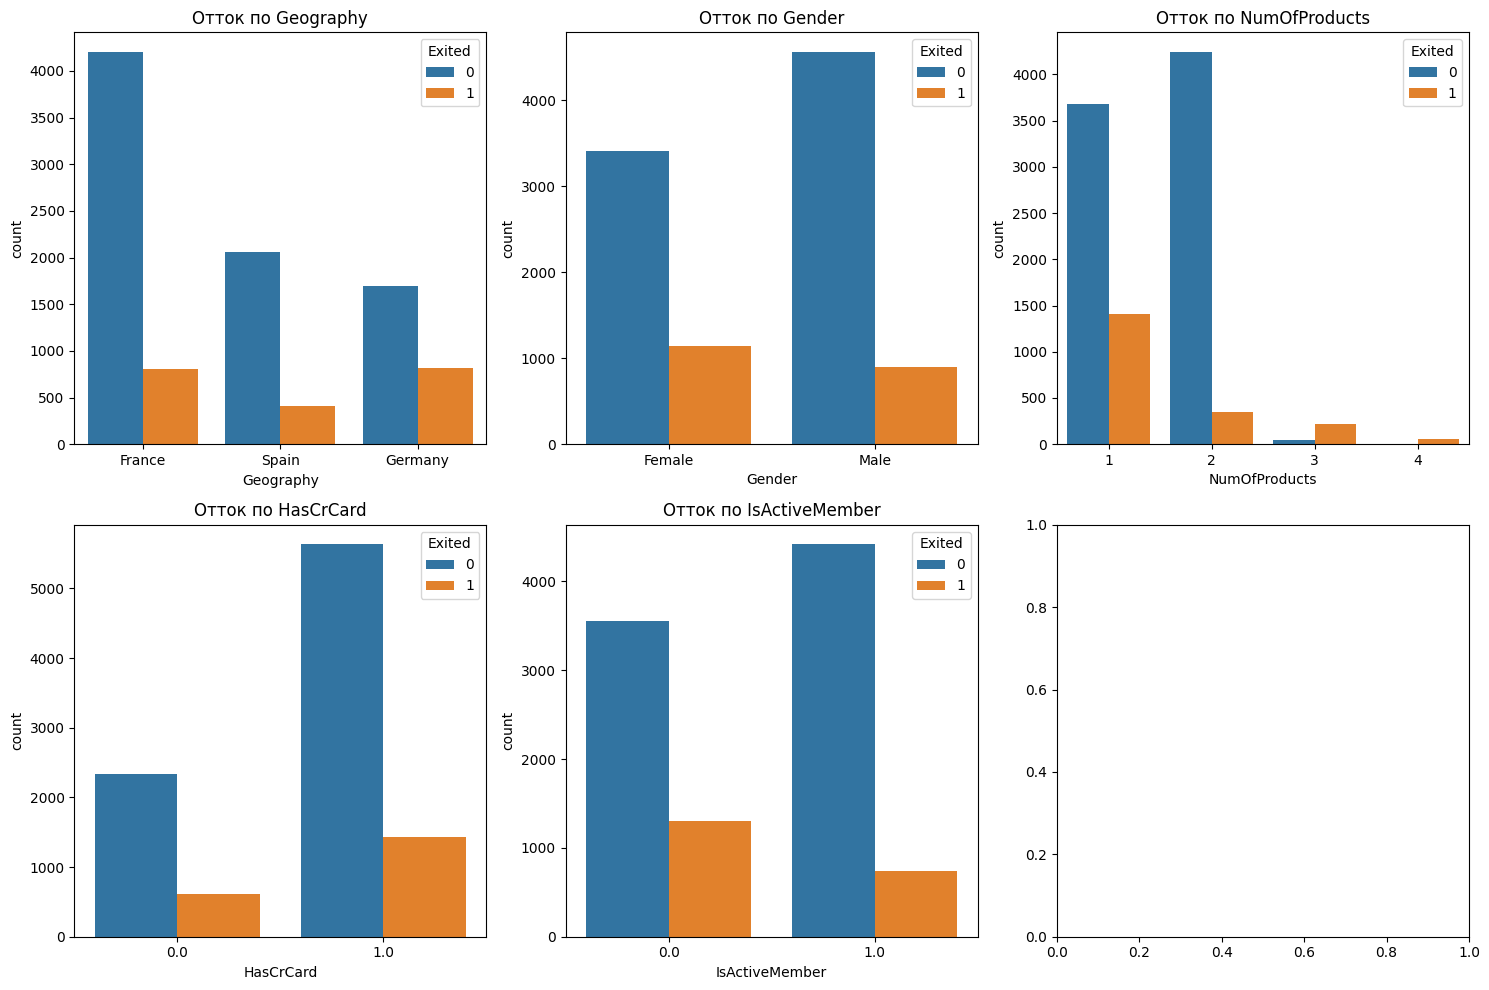

In [85]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(categorical_features):
    ax = axes[i//3, i%3]
    sb.countplot(data=df, x=col, hue='Exited', ax=ax)
    ax.set_title(f'Отток по {col}')
    
plt.tight_layout()
plt.show()

In [86]:
for column in categorical_features:
    product_churn = df.groupby(column)['Exited'].mean() * 100
    print(product_churn)
    print('-'*50)

Geography
France     16.154767
Germany    32.470120
Spain      16.673395
Name: Exited, dtype: float64
--------------------------------------------------
Gender
Female    25.066021
Male      16.471235
Name: Exited, dtype: float64
--------------------------------------------------
NumOfProducts
1     27.708948
2      7.601830
3     82.706767
4    100.000000
Name: Exited, dtype: float64
--------------------------------------------------
HasCrCard
0.0    20.814941
1.0    20.195578
Name: Exited, dtype: float64
--------------------------------------------------
IsActiveMember
0.0    26.860441
1.0    14.271845
Name: Exited, dtype: float64
--------------------------------------------------


In [87]:
print(df['NumOfProducts'].value_counts())

NumOfProducts
1    5085
2    4591
3     266
4      60
Name: count, dtype: int64


По представленным диаграммам, можем сделать следующие выводы:

- Больше всего клиентов уходит из Германии, причем доля ушедших в этой стране наибольшая
- Женщины склонны к оттуку больше (25%), чем мужчины (16%)
- Люди, которые имеют несколько продуктов банка (3-4) наиболее склонны к оттоку - 82% и 100% соответственно. Однако таких людей (кто имеет 3-4 продукта) мало, поэтому статистика ненадежна. Те кто имеет один продукт банка уходят в среднем в 27% случаев. У кого имеется два продукта банка - уходят в 7% случаев
- Показатель "Наличие кредитной карты" одинаково влияет на отток - по 20%
- Неактивные клиенты уходят чаще - 26% против 14%

## 🔢 2.3 Исследование числовых признаков

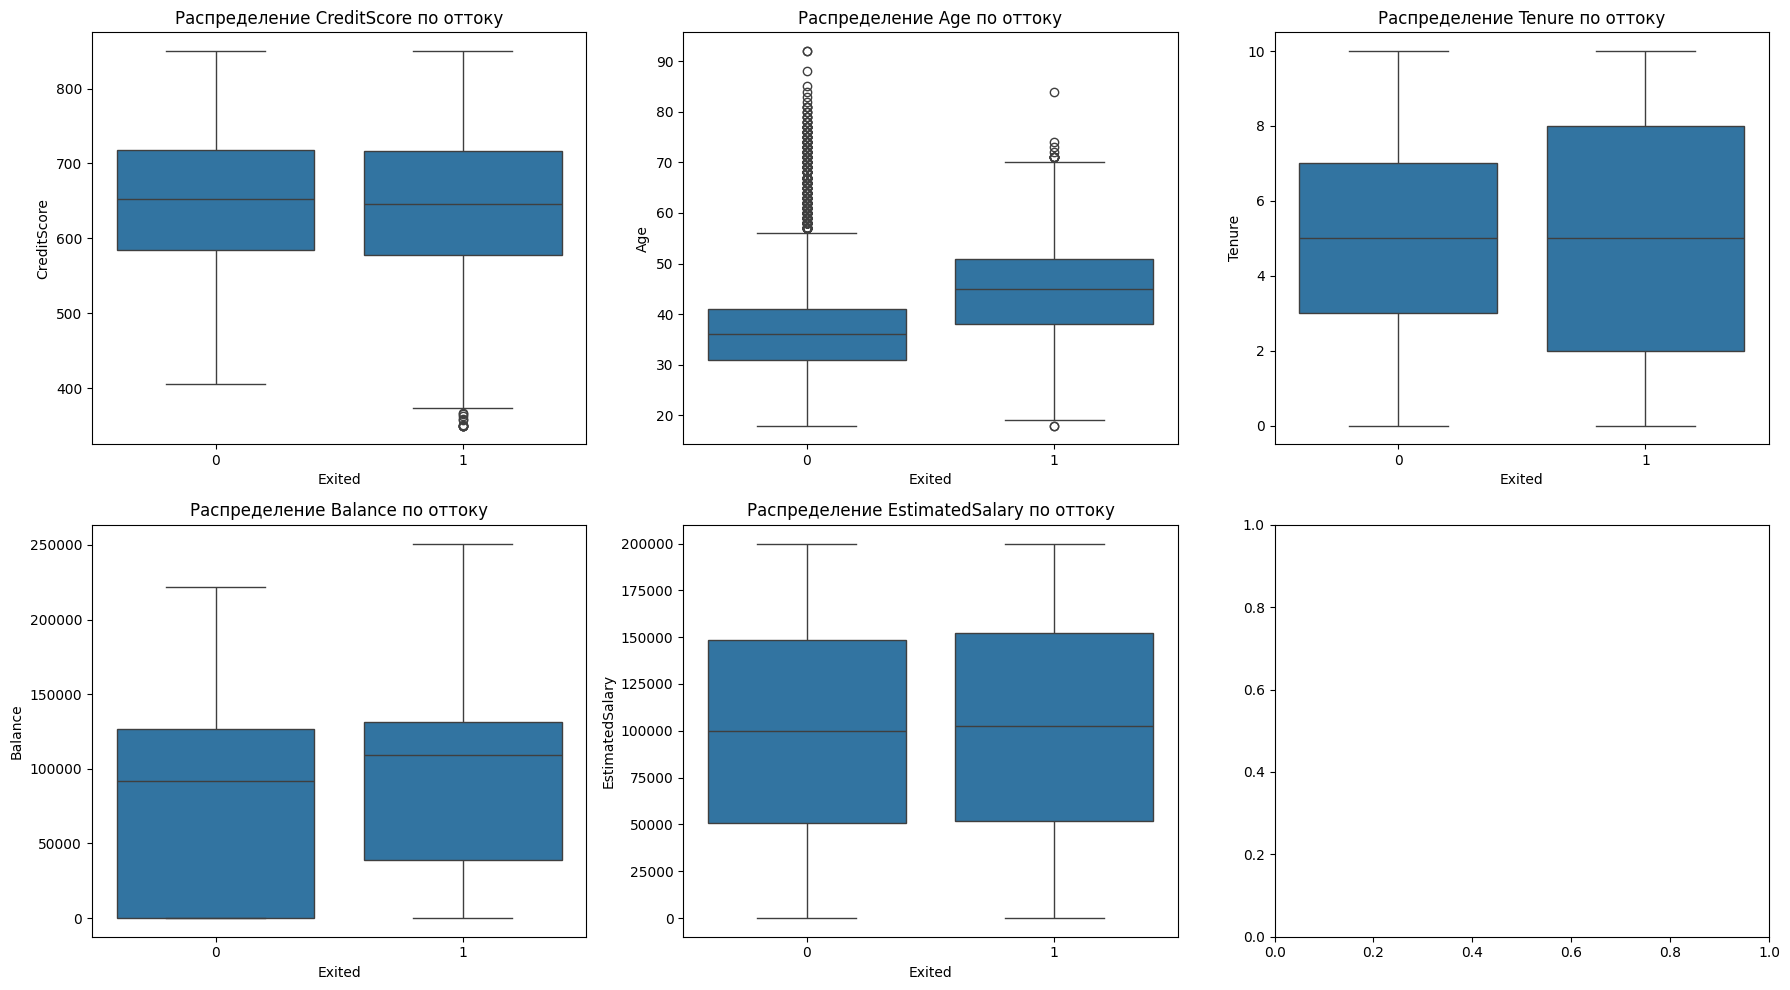

In [88]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, col in enumerate(numeric_features):
    ax = axes[i//3, i%3]
    sb.boxplot(data=df, x='Exited', y=col, ax=ax)
    ax.set_title(f'Распределение {col} по оттоку')
    
plt.tight_layout()
plt.show()

По представленным box-plot диаграммам, можем сделать следующие выводы:

- Признак `CreditScore`: Медианы примерно одинаковые, IQR совпадают -> признак слабо влияет на отток в отрыве от других факторов
- Признак `Age`: - Медиана у ушедших клиентов ~44 года vs ~35 лет у лояльных, IQR почти не пересекаются → возраст сильно влияет на отток, Есть выбросы в старшем возрасте (>57 лет). **Вывод:** Клиенты старше 40 лет значительно чаще уходят из банка.
- Признак `Tenure`: Медианы примерно одинаковые, IQR Пересекаются -> признак слабо влияет на отток
- Показатель `Balance`: Медиана у ушедших клиентов ~120000 vs ~90000 у лояльных, IQR перекрываются -> Баланс на счете не сильно влияет на отток; много нулевых балансов, особенно в группе ушедших клиентов
- Принзак `EstimatedSalary`: Медианы примерно одинаковые, IQR совпадают -> признак слабо влияет на отток в отрыве от других факторов

## 2.4 ❓Математическое подтверждение гипотез

In [89]:
df.loc[df['Age'].isna(), 'Age'] = df['Age'].mean()

In [ ]:
from scipy.stats import mannwhitneyu

def check_numerical_significance(df, numerical_cols):
    results = {}
    for col in numerical_cols:
        group_0 = df[df['Exited'] == 0][col]
        group_1 = df[df['Exited'] == 1][col]
        
        stat, p_value = mannwhitneyu(group_0, group_1)
        
        n1, n2 = len(group_0), len(group_1)
        
        U1 = stat
        U2 = n1 * n2 - U1
        U = min(U1, U2)
        
        effect_size = U / (n1 * n2)
        
        med_0, med_1 = group_0.median(), group_1.median()
        
        results[col] = {
            'p_value': p_value,
            'significant': p_value < 0.05,
            'effect_size': effect_size,
            'med_0': med_0,
            'med_1': med_1,
            'interpretation': '🚀 СИЛЬНЫЙ' if effect_size < 0.4 else 
                             '📊 УМЕРЕННЫЙ' if effect_size < 0.45 else '📉 СЛАБЫЙ'
        }
    
    return results

significance_results = check_numerical_significance(df, numeric_features)

print("🔍 Статистическая значимость числовых признаков:")
for col, result in significance_results.items():
    print(f"{col}: p-value={result['p_value']:.4f}, effect={result['effect_size']:.3f}"
          f"(Exited=1: {result['med_1']:.1f} vs Exited=0: {result['med_0']:.1f}) - {result['interpretation']}")

🔍 Статистическая значимость числовых признаков:
CreditScore: p-value=0.0209, effect=0.483(Exited=1: 646.0 vs Exited=0: 653.0) - 📉 СЛАБЫЙ
Age: p-value=0.0000, effect=0.268(Exited=1: 45.0 vs Exited=0: 36.0) - 🚀 СИЛЬНЫЙ
Tenure: p-value=0.1587, effect=0.490(Exited=1: 5.0 vs Exited=0: 5.0) - 📉 СЛАБЫЙ
Balance: p-value=0.0000, effect=0.422(Exited=1: 109344.2 vs Exited=0: 92093.1) - 📊 УМЕРЕННЫЙ
EstimatedSalary: p-value=0.2260, effect=0.491(Exited=1: 102431.9 vs Exited=0: 99620.4) - 📉 СЛАБЫЙ


In [91]:
from scipy.stats import chi2_contingency

def check_categorical_significance(df, categorical_cols):
    results = {}
    for col in categorical_cols:
        contingency_table = pd.crosstab(df[col], df['Exited'])
        
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        n = contingency_table.sum().sum()
        cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
        
        results[col] = {
            'p_value': p_value,
            'significant': p_value < 0.05,
            'cramers_v': cramers_v,
            'interpretation': '🚀 СИЛЬНЫЙ' if cramers_v > 0.3 else 
                             '📊 УМЕРЕННЫЙ' if cramers_v > 0.1 else '📉 СЛАБЫЙ'
        }
    
    return results

cat_significance = check_categorical_significance(df, categorical_features)

for col, result in cat_significance.items():
    print(f"{col}: p-value={result['p_value']:.4f}, Cramér's V={result['cramers_v']:.3f} ({result['interpretation']})")

Geography: p-value=0.0000, Cramér's V=0.174 (📊 УМЕРЕННЫЙ)
Gender: p-value=0.0000, Cramér's V=0.106 (📊 УМЕРЕННЫЙ)
NumOfProducts: p-value=0.0000, Cramér's V=0.387 (🚀 СИЛЬНЫЙ)
HasCrCard: p-value=0.5005, Cramér's V=0.007 (📉 СЛАБЫЙ)
IsActiveMember: p-value=0.0000, Cramér's V=0.156 (📊 УМЕРЕННЫЙ)
